In [ ]:
# 1. Imports and setup
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import numpy as np

! git clone https://github.com/modraa-pixels/Snow-Covered-Roads-Dataset.git # Not from the research paper but a similar dataset uas used

# Set Dataset Paths
train_dir = "/content/Snow-Covered-Roads-Dataset/dataset/train" #Tells tesorflow that where the training folders are in the download repo
test_dir = "/content/Snow-Covered-Roads-Dataset/dataset/test" #Same as above but for testing.

# This is for VS Code. You just need to set your user path based on where you cloned your GitHub repository.
# Simply replace the square brackets with your actual path.
# train_dir = r"[Drive]:\[Username]\[Path]\Snow-Covered-Roads-Dataset\dataset\train"
# test_dir = r"[Drive]:\[Username]\[Path]\Snow-Covered-Roads-Dataset\dataset\test"

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os

# Load in final_weather_data.csv and final_image_metadata.csv
weather_data_df = pd.read_csv('/content/drive/MyDrive/snow_scrape_project/final_weather_data.csv')
image_metadata_df = pd.read_csv('/content/drive/MyDrive/snow_scrape_project/final_image_metadata.csv')

# This is for VS Code.
# weather_data_df = pd.read_csv(r'[Drive]:\[Username]\[Path]\final_weather_data.csv')
# image_metadata_df = pd.read_csv(r'[Drive]:\[Username]\[Path]\final_image_metadata.csv')

# ----------------------------------------------------------------------
# Revised Image and Weather Data Handling
print("\n--- Revised Image and Weather Data Handling ---")

# 1. Get all image filenames from train_dir
all_image_files = []
for label in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir, label)):
        for file in os.listdir(os.path.join(train_dir, label)):
            all_image_files.append(file) # Store just the filename

all_image_filenames_set = set(all_image_files)
weather_filenames_set = set(weather_data_df['filename'].tolist())

# 2. Find common filenames
common_filenames = list(all_image_filenames_set.intersection(weather_filenames_set))
print(f"Number of common filenames between image data and weather data: {len(common_filenames)}")

# 3. Filter image metadata and weather data to keep only common filenames
common_image_metadata_df = image_metadata_df[image_metadata_df['filename'].isin(common_filenames)]
common_weather_data_df = weather_data_df[weather_data_df['filename'].isin(common_filenames)]

print(f"Shape of common_image_metadata_df: {common_image_metadata_df.shape}")
print(f"Shape of common_weather_data_df: {common_weather_data_df.shape}")

# 4. Create a mapping of filename to label from the directory structure
filename_to_label = {}
for label in os.listdir(train_dir):
    if os.path.isdir(os.path.join(train_dir, label)):
        for file in os.listdir(os.path.join(train_dir, label)):
            if file in common_filenames:
                filename_to_label[file] = label

# 5. Create a dataframe with filepaths and labels for the common images
image_data_for_split = []
for filename in common_filenames:
    label = filename_to_label.get(filename)
    if label:
        image_data_for_split.append((os.path.join(train_dir, label, filename), label))

image_df_for_split = pd.DataFrame(image_data_for_split, columns=['filepath', 'label'])

# 6. Split the common image data into training and testing sets
train_df_filenames, test_df_filenames = train_test_split(image_df_for_split, test_size=0.2, random_state=42, stratify=image_df_for_split['label'])

print(f"Number of training image filepaths (after filtering): {len(train_df_filenames)}")
print(f"Number of testing image filepaths (after filtering): {len(test_df_filenames)}")

print("--- End Revised Image and Weather Data Handling ---\n")
# ----------------------------------------------------------------------


In [ ]:
# 2. Load and preprocess image dataset with data augmentation
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_NAMES = sorted(os.listdir(train_dir))
NUM_CLASSES = len(CLASS_NAMES)
print("Class names:", CLASS_NAMES)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Load the image, set it as JPEG, resizes it to fix the shape, and normalizes the pixel values so it can return it with the label
def load_and_preprocess_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Setup the dataset into the TensorFlow dataset so the training later will be better
def prepare_dataset(df, batch_size, augment=False):
    labels = df['label'].apply(lambda x: CLASS_NAMES.index(x)).tolist()
    ds = tf.data.Dataset.from_tensor_slices((df['filepath'].tolist(), to_categorical(labels, num_classes=NUM_CLASSES)))
    ds = ds.map(load_and_preprocess_image)
    if augment:
        ds = ds.map(lambda image, label: (data_augmentation(image, training=True), label))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds_augmented = prepare_dataset(train_df_filenames, BATCH_SIZE, augment=True)
test_ds = prepare_dataset(test_df_filenames, BATCH_SIZE)

# ----------------------------------------------------------------------
# Added code for testing dataset lengths
print("\n--- Dataset Length Verification ---")
print(f"Number of training image filepaths: {len(train_df_filenames)}")
print(f"Number of testing image filepaths: {len(test_df_filenames)}")

# Calculate the number of batches in each dataset
num_train_batches = len(train_ds_augmented)
num_test_batches = len(test_ds)

# Calculate the total number of images in each dataset
total_train_images = num_train_batches * BATCH_SIZE
total_test_images = num_test_batches * BATCH_SIZE

print(f"Number of training batches: {num_train_batches}")
print(f"Total images in train_ds_augmented: {total_train_images}")
print(f"Number of testing batches: {num_test_batches}")
print(f"Total images in test_ds: {total_test_images}")

# Verify total number of images against original dataframes
print(f"Total images in train_df_filenames: {len(train_df_filenames)}")
print(f"Total images in test_df_filenames: {len(test_df_filenames)}")

print("--- End Dataset Length Verification ---\n")
# ----------------------------------------------------------------------

print(len(weather_data_df))


Class names: ['clear', 'light', 'medium', 'plowed']

--- Dataset Length Verification ---
Number of training image filepaths: 26792
Number of testing image filepaths: 6698
Number of training batches: 838
Total images in train_ds_augmented: 26816
Number of testing batches: 210
Total images in test_ds: 6720
Total images in train_df_filenames: 26792
Total images in test_df_filenames: 6698
--- End Dataset Length Verification ---

33490


In [ ]:
# 3. Build and train a small ResNet model with Batch Normalization
# Input and output match with three layers and batch normalization
def identity_block(x, filter):
    shortcut = x
    x = layers.Conv2D(filter, (1, 1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter * 4, (1, 1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Input and output dimension match with relu
def convolutional_block(x, filter, s=2):
    shortcut = x
    x = layers.Conv2D(filter, (1, 1), strides=(s, s), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter, (3, 3), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filter * 4, (1, 1), strides=(1, 1), padding='valid')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv2D(filter * 4, (1, 1), strides=(s, s), padding='valid')(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# ResNet Model with relu, softmax, etc...
def create_small_resnet():
    input_tensor = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = convolutional_block(x, 64, s=1)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = identity_block(x, 128)
    x = layers.AveragePooling2D((7, 7))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs=input_tensor, outputs=x)
    return model

resnet_model = create_small_resnet()
resnet_model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

resnet_model.summary()

# Train the model
history_resnet = resnet_model.fit(
    train_ds_augmented,
    epochs=30,
    validation_data=test_ds,
    verbose=1
)

NOTE: If you're wondering why there are screenshots based on the code output, it's because we're using this link to download and run the model locally on the computer. Hence the inclusion of screenshots.

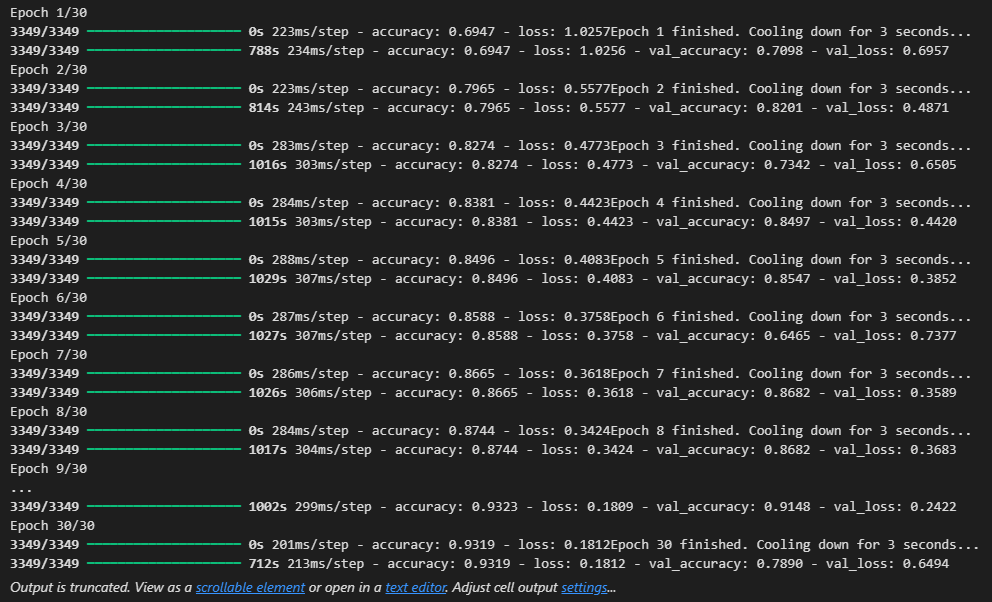

In [ ]:
# 5. Evaluate ResNet
loss_resnet, acc_resnet = resnet_model.evaluate(test_ds)
print(f"ResNet Test Accuracy: {acc_resnet:.4f}")

# Predictions
y_pred_probs_resnet = resnet_model.predict(test_ds)
y_pred_resnet = np.argmax(y_pred_probs_resnet, axis=1)
y_true_resnet = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)
class_names_arr = np.array(CLASS_NAMES)

# Report
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names_arr))

# Confusion Matrix
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_arr, yticklabels=class_names_arr)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet Confusion Matrix")
plt.show()

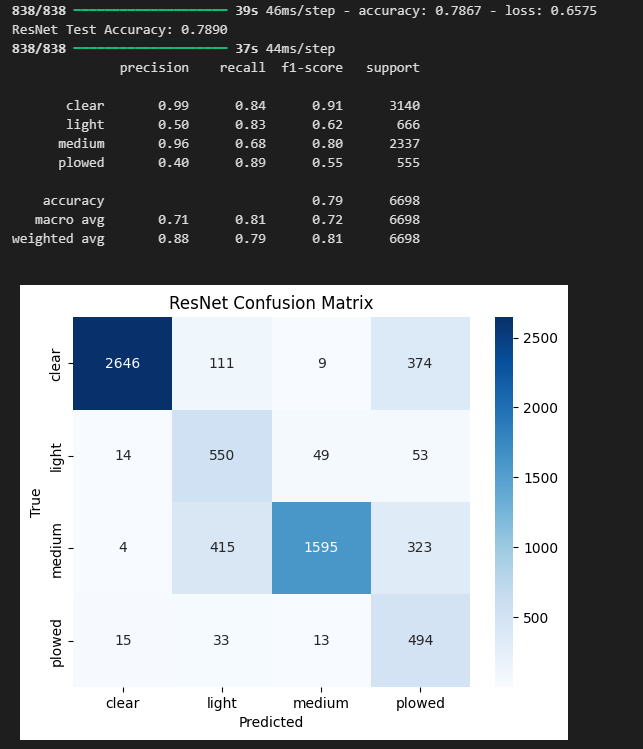